In [ ]:
# Testing code using dask to write and read zarr files from mp4 videos

In [2]:

import cv2
import numpy as np
import matplotlib

In [ ]:
# notebook dev
%load_ext autoreload
%autoreload 2
%matplotlib inline

ModuleNotFoundError: No module named 'matplotlib'

In [8]:
 # Step 1: Load video frames and create Dask array
video_path = '/root/capsule/data/multiplane-ophys_731327_2024-08-23_13-22-02/behavior-videos/1388918966_Face_20240823T132146.mp4'


In [9]:
cap = cv2.VideoCapture(video_path)

In [10]:
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
num_frames

228224

In [11]:
H,W = 492, 658
#video_shape=(num_frames, H, W)
#chunks = (100, H, W)
chunk_size = 100  # Number of frames to process at a time
frame_shape = (H, W)  # Height and Width of each frame


In [17]:

zarr_path = '/root/capsule/scratch/test3.zarr'
zarr_store_frames = zarr.DirectoryStore(zarr_path)


In [18]:
def process_chunk(start, chunk_size, frame_shape):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start)  # Set starting frame
    chunk = []
    for i in range(chunk_size):
        ret, frame = cap.read()
        if not ret:
            break  # Stop if no frame is returned (end of video)
        # Convert to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Resize the frame to the target frame shape
        gray_frame = cv2.resize(gray_frame, (frame_shape[1], frame_shape[0]))
        chunk.append(gray_frame)
    cap.release()
    return np.stack(chunk)

In [29]:
# Step 2: Load and process chunks in parallel using Dask Delayed
chunks = []
for start in range(1, num_frames, chunk_size):
    delayed_chunk = dask.delayed(process_chunk)(start, chunk_size, frame_shape)
    chunks.append(delayed_chunk)

In [20]:
zarr_store_frames.dir_path()

'/root/capsule/scratch/test3.zarr'

In [30]:
np.shape(chunks)

(2283,)

In [31]:
# Compute all chunks in parallel, convert to a Dask array, and save to Zarr
dask_chunks = [
    da.from_delayed(chunk, shape=(min(chunk_size, num_frames - start), *frame_shape), dtype='f4') 
    for start, chunk in zip(range(0, num_frames, chunk_size), chunks)
]
dask_array = da.concatenate(dask_chunks, axis=0)
dask_array.to_zarr(zarr_store_frames, overwrite=True)

ValueError: parameter 'value': expected array with shape (24, 492, 658), got (23, 492, 658)

In [26]:
dask_array[2283]

dask.array<getitem, shape=(492, 658), dtype=float32, chunksize=(492, 658), chunktype=numpy.ndarray>

In [14]:

# Load the grayscale frames from the Zarr file
zarr_store_motion = zarr.DirectoryStore('/root/capsule/scratch/motion_energy_grayscale.zarr')
motion_energy = da.from_zarr(zarr_store_motion)


In [15]:
grayscale_frames

dask.array<from-zarr, shape=(287998, 492, 658), dtype=float32, chunksize=(100, 492, 658), chunktype=numpy.ndarray>

In [21]:

# Compute motion energy as the absolute difference between consecutive frames
# This will be a Dask array operation that only loads and computes chunks as needed
motion_energy = da.abs(grayscale_frames[1:] - grayscale_frames[:-1])

# Define the chunking for efficient memory usage; rechunk if necessary
motion_energy = motion_energy.rechunk((100, H, W))  # Adjust based on available memory

# Save motion energy as a new Zarr file
zarr_store_motion = zarr.DirectoryStore('/root/capsule/scratch/motion_energy_grayscale.zarr')
motion_energy.to_zarr(zarr_store_motion, overwrite=True)

# Compute the sum of motion energy for each frame and save as a NumPy array
# This sums across height and width to get the sum per frame (along the time dimension)
motion_energy_sum = motion_energy.sum(axis=(1, 2)).compute()

# Save the result as a NumPy array
np.save('/root/capsule/scratch/motion_energy_sum.npy', motion_energy_sum)

print("Motion energy computation and saving complete.")

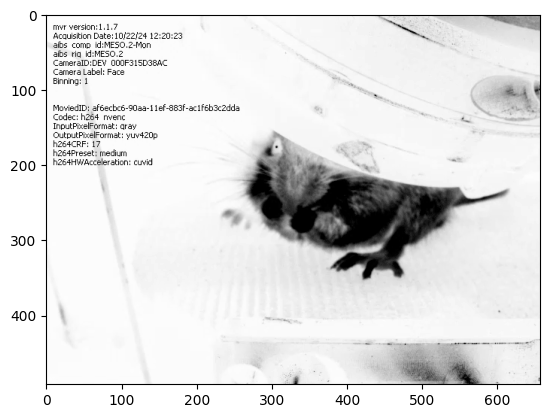

In [21]:
import matplotlib.pyplot as plt
plt.imshow(motion_energy[0], cmap='gray')